In [2]:
#%pip install pandas
#%pip install xlrd

# Issues and fixes with data
* df values aren't numeric automatically 
    * --> force them to numeric 
* Not sure if issue but should scale/standardize the data before feeding it to the algorithms (heatmapping thing)
    * Since the data should be scaled for some methods/things (like PCA) that aren't robust, using the same for all.

In [3]:
import pandas as pd

# Importing the data
df = pd.read_excel('Metall. Application.xls')

# Setting the column names 
df.columns = df.iloc[0,:]
df.drop(df.index[0], inplace=True)

# Grab just the relevant data for the objectives
# Using .copy() just in case, don't wanna accidentally mess up original df
data = df.iloc[:739, :].copy()

# Forcing non numerics to turn into NaNs, maybe a bad idea? TODO: find out
# Doesn't look like it will cause any issues because everything can be turned into a number so all good (I think)
data = data.apply(pd.to_numeric, errors='coerce')


# Not sure if this is needed, but let's save it.
# I think it has the min and max values for each data element.
df_minmax = df.iloc[741:, :].copy()

# Info: three objective functions
* _Each row contains information about a particular alloy composition.
Columns A-C and F-Z contain information about concentration of various alloying
elements in the steel. Note: Niobium (Nb) and Columbium (Cb) are infact,
the same element._
* The properties of note are: 
    * yield strength (in MPa, Column AD or 'YS(Mpa)')
    * ultimate tensile strength (in Mpa, Column AE or 'UTS(Mpa)')
    * and percentage elongation before fracture (unitless, column AF or '%EL')


# 1. Processing the data 
_Process the data such that you are able to use it for surrogate modelling. Describe the process._

Splitting the data into three different dataframes, one for each objective. Will not be including columns A-C since they are repeated in columns F-Z. I don't know why there are duplicates but it is confusing. 
(_They are not exact duplicates (for example, the last values in Nb columns are different), but I will be running with the F-Z columns_) Dropping all NaN valued rows from each dataframe.

Also standardized the data here

In [4]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()

# Getting elements from C to Sn
elements = data.iloc[:, data.columns.get_loc('C'):df.columns.get_loc('Sn')].copy()

# Combining Nb and Cb since they are the same
elements['Nb'] = elements['Nb'] + elements['Cb']

# Drop the Cb column 
elements.drop(columns=['Cb'], inplace=True)
# print(elements.columns) 

ys = data['YS(Mpa)']
df_ys = pd.concat([elements, ys], axis=1).dropna()  # Combining elements and the "objective", dropping nans
df_ys = df_ys.apply(pd.to_numeric, errors='coerce')  # Turning into numbers, if not a number
df_ys_arr = scaler.fit_transform(df_ys) # Standardizing the data, it returns an array
scaled_df_ys = pd.DataFrame(df_ys_arr, columns=df_ys.columns) # Turn it back into a DataFrame
# print(len(scaled_df_ys))

uts = data['UTS(Mpa)']
df_uts = pd.concat([elements, uts], axis=1).dropna()
df_uts = df_uts.apply(pd.to_numeric, errors='coerce')
df_uts_arr = scaler.fit_transform(df_uts) 
scaled_df_uts = pd.DataFrame(df_uts_arr, columns=df_uts.columns) 
# print(len(df_uts))

elong = data['%EL']
df_elong = pd.concat([elements, elong], axis=1).dropna()
df_elong = df_elong.apply(pd.to_numeric, errors='coerce')
df_elong_arr = scaler.fit_transform(df_elong) 
scaled_df_elong = pd.DataFrame(df_elong_arr, columns=df_elong.columns) 


Calculating the importance of elements for each of the three objectives and then removing non-important ones.

_Only had time to implement one method, and even that is not giving the same results as in the paper._

* Principal component analysis (PCA): 
    * PCA reduces the dimensionality of the data, retains most of the variation in the dataset
    * The first component explains the most variance in the data, the second (orthogonal to the first) explains the second most etc
    * Need to find the amount of principal components that explain a significant (90% or more) amount of the variation in data
    * Of these PCs, check out their composition:
        * the absolute value corresponding to each of the alloys (C is the first one and so on) tells how important it is to the alloy to the variance, so that is what we wanna measure
    


In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

np.random.seed(42)

# Separating the features (elements) and the target variable (YS)
X_ys = scaled_df_ys.drop(columns=['YS(Mpa)'])
y_ys = scaled_df_ys['YS(Mpa)']  # not needed right now but maybe later

# Calculate all the components
pca = PCA()
pca.fit_transform(X_ys)
print(pca.explained_variance_ratio_)


[1.81260446e-01 1.11449205e-01 1.01353198e-01 8.31444727e-02
 7.72741685e-02 6.60032469e-02 5.94749315e-02 5.38491472e-02
 4.95007938e-02 4.56273063e-02 3.35638308e-02 3.10533623e-02
 2.69622882e-02 2.22649895e-02 1.96201073e-02 1.50029574e-02
 1.20228971e-02 1.05726521e-02 1.90855595e-34]


Based on the above, we can see that the first component explains about 48% of the variance in the data, and the second 35%, third about 7%. I'd say that those three added together (about 90%) is a significant amount, let's work with that.

In [6]:
# Working with three first components
pca = PCA(n_components=3)
pca.fit_transform(X_ys)

V = pca.components_.T

# TODO: Figure out where the row with 0 index comes from and fix it, it irks me
pd.DataFrame(V, columns=['PC1', 'PC2', 'PC3'], index=elements.columns)


,PC1,PC2,PC3
0,,,
C,-0.317171,0.026189,0.439870
Si,-0.451723,0.010515,-0.175170
Mn,-0.291736,-0.025066,-0.305882
P,-0.423346,-0.167662,0.169801
S,-0.382973,-0.076937,0.365582
Mo,0.033116,0.469636,0.149695
Ni,0.043004,0.606364,0.031032
Al,-0.099215,0.043193,-0.433125
N,-0.124085,-0.107281,-0.249098


Logic: the higher the absolute value, the more important the alloy is to the variance.


**BUTTT:** How to quantify this? For each element we have three values, should those just be summed up, with weigths or something? The elements should be ranked from important to least important, in a relative manner. Obviously Ca is the least significant, because it is zero in all values, but how about the others?

I do not know, this might be stupid, but Imma sum them up using weigths according to the variance the component explains so: 0.48 for the first one, 0.35 for the second and 0.07 for the third.

In [7]:
# The variance ratios each component explains
ratios = pca.explained_variance_ratio_

# Sum the values along each row
importance = np.sum(np.abs(V) * ratios, axis=1)

# Making a new dataframe, based on which it is easy to plot the thing
df_importance = pd.DataFrame(importance, columns=['sum'], index=elements.columns)
# Calculating the relative importance as rank 
# for example Ca is ranked #1 --> least important
df_importance['Relative Importance'] = df_importance['sum'].abs().rank(ascending=True)
df_importance

,sum,Relative Importance
0,,
C,0.104991,17.0
Si,0.100805,16.0
Mn,0.086676,14.0
P,0.112631,18.0
S,0.115045,19.0
Mo,0.073515,11.0
Ni,0.078519,12.0
Al,0.066696,8.0
N,0.059695,6.0


Looks like the results aren't exatly the same as in the paper. Perhaps I did something silly or downright stupid, or maybe it is just different. However, Imma run with it

Doing the same operations to the other two dataframes

## PCA for UTS

In [8]:
# Separating the features (elements) and the target variable (YS)
X_uts = scaled_df_uts.drop(columns=['UTS(Mpa)'])
y_uts = scaled_df_uts['UTS(Mpa)']  # not needed right now but maybe later

# 3 PCs explain over 90% of the variation, examining those the same way as before
pca = PCA(n_components=3)
pca.fit_transform(X_uts)
print("Three first PCs explain:", sum(pca.explained_variance_ratio_)*100, "% of the variance")

# The variance ratios each component explains
ratios = pca.explained_variance_ratio_

# Sum the values along each row
importance = np.sum(np.abs(V) * ratios, axis=1)

# Making a new dataframe, based on which it is easy to plot the thing
df_importance_uts = pd.DataFrame(importance, columns=['sum'], index=elements.columns)
# Calculating the relative importance as rank 
# for example Ca is ranked #1 --> least important
df_importance_uts['Relative Importance'] = df_importance_uts['sum'].abs().rank(ascending=True)
df_importance_uts


Three first PCs explain: 38.37269894151589 % of the variance


,sum,Relative Importance
0,,
C,0.094155,17.0
Si,0.084913,14.0
Mn,0.076784,11.0
P,0.101800,18.0
S,0.103213,19.0
Mo,0.084357,13.0
Ni,0.092592,16.0
Al,0.064057,8.0
N,0.057916,6.0


In [9]:
# Separating the features (elements) and the target variable (YS)
X_elong = scaled_df_elong.drop(columns=['%EL'])
y_elong = scaled_df_elong['%EL']  # not needed right now but maybe later

# Just 2 PCs explain over 90% of the variance, but adding the third too so I don't need to modify the code
pca = PCA(n_components=3)
pca.fit_transform(X_elong)
print("Three first PCs explain:", sum(pca.explained_variance_ratio_)*100, "% of the variance")

# The variance ratios each component explains
ratios = pca.explained_variance_ratio_

# Sum the values along each row
importance = np.sum(np.abs(V) * ratios, axis=1)

# Making a new dataframe, based on which it is easy to plot the thing
df_importance_elong = pd.DataFrame(importance, columns=['sum'], index=elements.columns)
# Calculating the relative importance as rank 
# for example Ca is ranked #1 --> least important
df_importance_elong['Relative Importance'] = df_importance_elong['sum'].abs().rank(ascending=True)
df_importance_elong


Three first PCs explain: 46.5049928597757 % of the variance


,sum,Relative Importance
0,,
C,0.118747,17.0
Si,0.109665,15.0
Mn,0.097249,13.0
P,0.127234,18.0
S,0.129877,19.0
Mo,0.095457,12.0
Ni,0.103371,14.0
Al,0.078709,8.0
N,0.070527,6.0


Text(0.5, 1.0, 'elong')

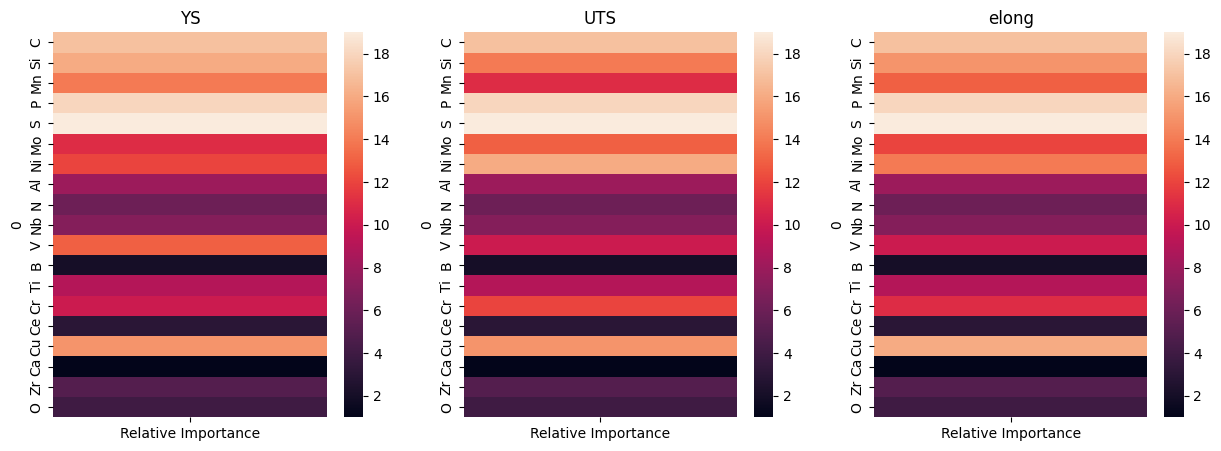

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,3, figsize=(15,5))
sns.heatmap(df_importance.drop(['sum'], axis=1), ax=axes[0])
axes[0].set_title('YS')
sns.heatmap(df_importance_uts.drop(['sum'], axis=1), ax = axes[1])
axes[1].set_title('UTS')
sns.heatmap(df_importance_elong.drop(['sum'], axis=1), ax = axes[2])
axes[2].set_title('elong')

#plt.savefig('heatmaps.jpg')

Calcium is not affecting the variance at all, but no wonder since neither of the datasets has any other value for calcium than 0. We can drop that column. Other's are left as is. 

Other than calcium, values aren't exactly same as in the paper results, this leads me to wonder if I have misunderstood something. It would also seem that the ranking for the values is pretty much identical (with a few exceptions) amongst the different datasets, which seems to correspond with the graphs in the paper, at least for the first two graphs(YS and UTS). 

Perhaps the results would be different if I calculated more PCs than just the first three. It wouldn't be that difficult, since the code is pretty  much already there, so maybe I will at some point. The coloring of the heatmaps is done based on rank, so even slight shifts between the values can affect the results a lot. It does not, however explain why Ni has such a high effect on variance in all cases here, when in the paper it should be the opposite. 


In [11]:
print(sum(df_ys['Ca']), sum(df_uts['Ca']), sum(df_elong['Ca']))

0.0 0.0 0.0


In [12]:
# Dropping the Ca column from all because it isn't doing anything
scaled_df_ys = scaled_df_ys.drop(['Ca'], axis = 1)
scaled_df_uts = scaled_df_uts.drop(['Ca'], axis = 1)
scaled_df_elong = scaled_df_elong.drop(['Ca'], axis = 1)

_In hidsight, PCA was extra, could have fitted a surrogate without it too_

# Surrogates
_From a pool of five surrogate modelling techniques of your choice, find out
which technique should be used for optimization. Describe your process._

Not sure how exactly am I supposed to find out which technique should be used for optimization. I have picked out five surrogate modeling techniques 

Surrogates: 
* kriging 
* support vector machines
* neural networks
* random forest
* linear regression

Surely we are not expected to implement all five. So let's try to reason it out. The data we are investigating is multidimensional and probably quite sparsely distributed. Based on that alone, linear regression would be out of picture, it won't work well with that. Same applies to kriging. Neural networks, support vector machines and random forests should be able to handle the data. I am, however, going to rule out using neural networks since they apparently didn't perform that well with the data (based on the K-fold cross validation performance screenshot in the lecture slides) and I find neural networks a bit tricky. Now we are left with two. That's doable. I'm picking SVR, fingers crossed that it will work with desdeo.

_Remember to operate on the scaled data_

Dumb baby: SVM only works with discrete data. Use SVR!

Fingers crossed one of these works with desdeo... 

# Hyperparameter tuning
Brief explanation of what was tuned and why:
* kernel type: could be rbf (radial basis function), or linear. 
    * obviously important, matters a lot on how the model is fit in the data
* the regularization parameter C
    * controls the fitting, with smaller value, the model will fit more close to the points
* the epsilon, which is basically the allowed error
    * for example, if epsilon is 0.1, that is by how much a datapoint is allowed to miss the "target" (I think)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import r2_score

# Splitting the data to test and training
X_ys_train, X_ys_test, y_ys_train, y_ys_test = train_test_split(X_ys, y_ys, test_size=0.3, random_state=42)

svr = svm.SVR()
svr.fit(X_ys_train, y_ys_train)
y_ys_pred = svr.predict(X_ys_test)

r2_score(y_ys_test, y_ys_pred)


0.7647908611743173

In [14]:
# Hyperparameter tuning, using gridsearch (not the most efficient but easy to understand)
# optimizing the kernel, C and epsilon, they seem the most important. Could also tune the other ones but I don't wanna make this too complex
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Let's just try with a few different ones, can always add more
param_grid = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'C': [1, 2, 2.5, 3, 4, 5, 7.5], # I don't know what values would be good for this, default is 1.0. C is the reg param TODO: literature suggests between 1-100
    'epsilon': [0.001, 0.005, 0.01, 0.05, 0.1]  # default 0.001, should be between that and 1
}

scorer = make_scorer(r2_score)

grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, scoring=scorer)
grid_search.fit(X_ys_train, y_ys_train)

results = grid_search.best_params_
C = results['C']
e = results['epsilon']
kernel = results['kernel']

svr_ys = svm.SVR(C=C, epsilon=e, kernel=kernel)
svr_ys.fit(X_ys_train, y_ys_train)
y_ys_pred = svr_ys.predict(X_ys_test)

score_ys = r2_score(y_ys_test, y_ys_pred)
print(results)
print('Score for YS: ', score_ys)


{'C': 2.5, 'epsilon': 0.1, 'kernel': 'rbf'}
Score for YS:  0.7514803633624859


Note: the gridsearch is quite slow, so I had to limit the amount of input going in, that is the variable choices so it would compile in an OK time. I did do some testing of the values and what might work. There might be a combo that works better but is not inputted. The results are good enough tho, so I'm running with it. 

Below just repeating the process to the other two 

In [15]:
# Splitting the data to test and training
X_uts_train, X_uts_test, y_uts_train, y_uts_test = train_test_split(X_uts, y_uts, test_size=0.3, random_state=42)

svr = svm.SVR()
svr.fit(X_uts_train, y_uts_train)
y_uts_pred = svr.predict(X_uts_test)

r2_score(y_uts_test, y_uts_pred)

# Let's just try with a few different ones, can always add more
param_grid = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'C': [2.5, 3, 4, 5, 7.5], # I don't know what values would be good for this, default is 1.0. C is the reg param TODO: literature suggests between 1-100
    'epsilon': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]  # default 0.001, should be between that and 1
}

scorer = make_scorer(r2_score)

grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, scoring=scorer)
grid_search.fit(X_uts_train, y_uts_train)

results = grid_search.best_params_
C = results['C']
e = results['epsilon']
kernel = results['kernel']

svr_uts = svm.SVR(C=C, epsilon=e, kernel=kernel)
svr_uts.fit(X_uts_train, y_uts_train)
y_uts_pred = svr_uts.predict(X_uts_test)

score_uts = r2_score(y_uts_test, y_uts_pred)
print(results)
print('Score for UTS: ', score_uts)


{'C': 7.5, 'epsilon': 0.1, 'kernel': 'rbf'}
Score for UTS:  0.7041656041309095


In [16]:
# Splitting the data to test and training
X_elong_train, X_elong_test, y_elong_train, y_elong_test = train_test_split(X_elong, y_elong, test_size=0.3, random_state=42)

svr = svm.SVR()
svr.fit(X_elong_train, y_elong_train)
y_elong_pred = svr.predict(X_elong_test)

r2_score(y_elong_test, y_elong_pred)

# Let's just try with a few different ones, can always add more
param_grid = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'C': [1, 2, 2.5, 3, 4, 5, 7.5], # I don't know what values would be good for this, default is 1.0. C is the reg param TODO: literature suggests between 1-100
    'epsilon': [0.001, 0.005, 0.009, 0.01, 0.02, 0.05, 0.1]  # default 0.001, should be between that and 1
}

scorer = make_scorer(r2_score)

grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, scoring=scorer)
grid_search.fit(X_elong_train, y_elong_train)

results = grid_search.best_params_
C = results['C']
e = results['epsilon']
kernel = results['kernel']

svr_elong = svm.SVR(C=C, epsilon=e, kernel=kernel)
svr_elong.fit(X_elong_train, y_elong_train)
y_elong_pred = svr_elong.predict(X_elong_test)

print(results)
score_elong = r2_score(y_elong_test, y_elong_pred)
print('Score for elong: ', score_elong)


{'C': 5, 'epsilon': 0.1, 'kernel': 'rbf'}
Score for elong:  0.6083535668352258


Everything else is acceptable, but for elong the value is only about 0.61, which is not great. In an ideal world I would try to fit another surrogate model, but I don't have time so this is what we are working with. 

# Problem implementation and solving

Doing this based on my implementation of the Assignment 1 problem.

In [17]:
from desdeo_problem import variable_builder
from desdeo_problem import _ScalarObjective
from desdeo_problem import MOProblem
from desdeo_mcdm.utilities.solvers import payoff_table_method
from desdeo_mcdm.interactive.ReferencePointMethod import ReferencePointMethod

In [18]:
# Variables
var_names = list(elements.columns)
initial_values = [0.1]*19  # Just some values
lower_bounds = [0]*19  # Obviously can't be negative
upper_bounds = [2]*19  # This might be a reasonable upper value (or not, I dunno)

variables = variable_builder(var_names, initial_values, lower_bounds, upper_bounds)


In [19]:
# Objectives (negated beccause the method is minimizing and the objectives originally maximizing)
objective1 = _ScalarObjective(name="f1", evaluator=lambda x: -svr_ys.predict(x))
objective2 = _ScalarObjective(name="f2", evaluator=lambda x: -svr_uts.predict(x))
objective3 = _ScalarObjective(name="f3", evaluator=lambda x: -svr_elong.predict(x))

# Problem implementation
problem = MOProblem(objectives=[objective1, objective2, objective3], variables=variables)

In [20]:
# This takes forever and it crashed my VS Code already once, so sod that. Pulling the values out of me arse.
# ideal, nadir = payoff_table_method(problem)

In [21]:
#help(minimize)

In [22]:
# Made these up, not actually calculated. 
# Remember: this is scaled data we are tinkering with, also switched from max to min so ideal and nadir flipped!!
nadir = np.array([200]*3) 
ideal = np.array([-3]*3)

# Can't get the minimize=[-1,-1,-1] to work so negated the objective functions, should work.
method = ReferencePointMethod(problem, ideal, nadir)


In [23]:
request = method.start()
# help(method.start)
print("Ideal: ", ideal)
print("Nadir: ", nadir)
print(request.content['message']) 

Ideal:  [-3 -3 -3]
Nadir:  [200 200 200]
Please specify a reference point as 'reference_point'.


In [24]:
# Just some point between ideal and nadir, not sure if realistic
# Hard to estimate with the scaled data and I couldnt get the transforming of the scaling to work
reference_point = np.array([1]*3)

# Adding the reference
request.response = {'reference_point': reference_point}


In [25]:
# This won't complete
#request = method.iterate(request)
#print(request.content.keys())